In [1]:
import pandas as pd
from air2waterpy import air2water
from air2waterpy.metrics import calc_nse
import matplotlib.pyplot as plt

In [2]:
# initialize a model
# 8p is the 8 parameter version
# you can select "6p" to use the 6 parameter version
model = air2water(version = "6p")

In [3]:
# Update parameter boundary based on the potential range of the mean lake depth
model.update_param_bnds(mean_depth_range=(140, 150))

In [4]:
# Load air temperature and water temperature data of Lake Superior
df = pd.read_csv("superior.csv", index_col=0, parse_dates=True)
# select calibration period
cal_period = pd.date_range("1995-01-01", "2004-01-01")
val_period = pd.date_range("2005-01-01", "2011-12-31")
cal_df = df.loc[cal_period]
val_df = df.loc[val_period]

In [5]:
# particle swarm optimization for calibration
# use 15 cpus for parallel calibration
cost, joint_vars = model.pso_fit(cal_df.tw, 
                                 cal_df.ta, 
                                 cal_period, 
                                 obj_func = "MSE", # the default objective function is MSE, you can use NSE as well
                                 th = 4.0, # The water temperature when the water density is at the highest point
                                 tw_init = 1.0, # Initial water temperature at the first time step
                                 tw_ice = 0.0, # Water temperature during ice cover
                                 swarm_size = 100, # swarm size
                                 n_cpus = 10, # number of threads for calibration
                                 iteration_num = 500, # maximum iteration
                                 options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}, # pyswarm parameters
                                 )

2024-11-19 11:33:16,175 - pyswarms.single.global_best - INFO - Optimize for 500 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|500/500, best_cost=3.83
2024-11-19 11:34:39,465 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 3.826073395809099, best pos: [0.56942668 0.04411045 0.16011326 5.83792771 0.98214961 0.69394742]


In [10]:
# load calibrated parameters
model.load_params(dict(zip(model._param_list, joint_vars)))

# print out model parameters
model.params

array([(0.56942668, 0.04411045, 0.16011326, 5.83792771, 0.98214961, 0.69394742)],
      dtype=[('a1', '<f8'), ('a2', '<f8'), ('a3', '<f8'), ('a4', '<f8'), ('a5', '<f8'), ('a6', '<f8')])

In [7]:
# simulate water temperature during validation period
val_tw_sim = model.simulate(val_df.ta, 
                            val_period,
                            th = 4.0,
                            tw_init = 1.0,
                            tw_ice = 0.0, 
                            )

In [8]:
print("NSE during the validation period is:", calc_nse(val_df.tw.to_numpy(), val_tw_sim.tw_sim.to_numpy()))

NSE during the validation period is: 0.8708184200146933


Text(0, 0.5, 'LSWT')

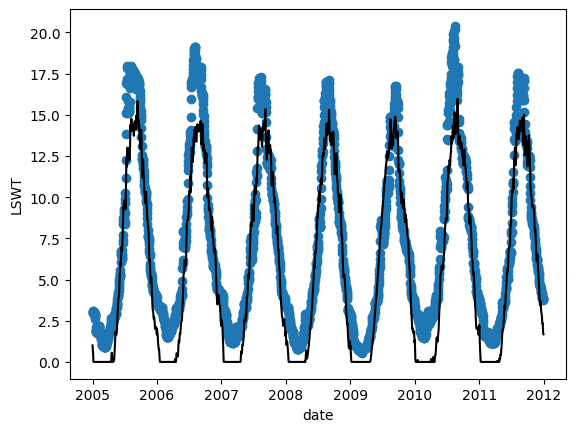

In [9]:
# plot the simulation performance
plt.scatter(val_period, val_df.tw)
plt.plot(val_tw_sim, color = "k")
plt.xlabel("date")
plt.ylabel("LSWT")